In [74]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer

In [75]:
dev = qml.device("default.qubit", wires=2)

In [76]:
@ct.electron
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [77]:
@ct.electron
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [78]:
@ct.electron
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [79]:
@ct.electron
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [80]:
@ct.electron
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [81]:
@ct.electron
def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

In [82]:
@ct.electron
def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [83]:
@ct.electron
def load_features(data):
    # pad the vectors to size 2^2 with constant values
    X = data[:, 0:2]
    print("First X sample (original)  :", X[0])

    padding = 0.3 * np.ones((len(X), 1))
    X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
    print("First X sample (padded)    :", X_pad[0])

    # normalize each input
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    print("First X sample (normalized):", X_norm[0])

    # angles for state preparation are new features
    features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
    Y = data[:, -1]
    return features,Y,X,X_norm,X_pad

In [84]:
data = np.loadtxt("./iris_classes1and2_scaled.txt")

features,Y,X,X_norm,X_pad = load_features(data)

print("First features sample      :", features[0])


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


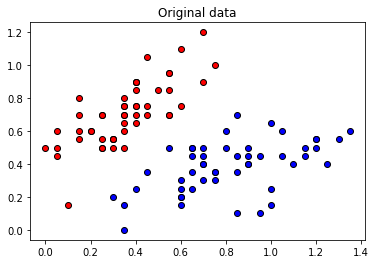

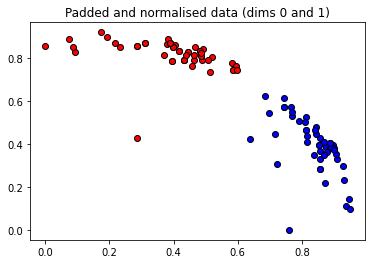

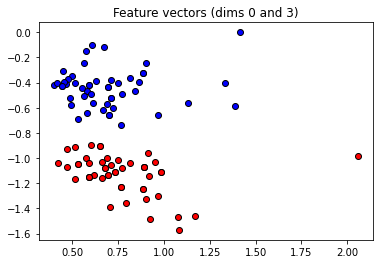

In [85]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()


In [86]:
@ct.electron
def train_val_split(features,Y):
    np.random.seed(0)
    num_data = len(Y)
    num_train = int(0.75 * num_data)
    index = np.random.permutation(range(num_data))
    feats_train = features[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feats_val = features[index[num_train:]]
    Y_val = Y[index[num_train:]]
    return feats_train,Y_train,feats_val,Y_val,index,num_train

In [87]:
# np.random.seed(0)
# num_data = len(Y)
# num_train = int(0.75 * num_data)
# index = np.random.permutation(range(num_data))
# feats_train = features[index[:num_train]]
# Y_train = Y[index[:num_train]]
# feats_val = features[index[num_train:]]
# Y_val = Y[index[num_train:]]
feats_train,Y_train,feats_val,Y_val,index,num_train = train_val_split(features,Y)

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [88]:
@ct.electron
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [89]:
@ct.electron
def weights_bias_init(num_qubits,num_layers):
    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)
    return weights_init,bias_init

In [90]:
@ct.electron
def get_optimizer():
    return NesterovMomentumOptimizer(0.01)

In [91]:
@ct.electron
def training(iterations,batch_size,weights,bias,num_train,feats_train,Y_train,opt,feats_val,Y_val,Y):
    print("beginning")
    training_steps = []
    accuracy_steps_train = []
    accuracy_steps_val = []
    weights_init = weights
    bias_init = bias
    for it in range(iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        print("Here")
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        print("Here1")
        weights_init, bias_init, _, _ = opt.step(cost, weights_init, bias_init, feats_train_batch, Y_train_batch)
        print("Here2")
        training_steps.append(it)
        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(weights_init, bias_init, f)) for f in feats_train]
        predictions_val = [np.sign(variational_classifier(weights_init, bias_init, f)) for f in feats_val]
        print("Here3")
        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)
        print("Here4")
        accuracy_steps_train.append(acc_train)
        accuracy_steps_val.append(acc_val)
        print("Here5")
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
        )
        return weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val


In [94]:
@ct.lattice
def workflow(iterations,num_train,num_layers,num_qubits,feats_train,Y_train,feats_val,Y_val,Y):
    opt = get_optimizer()
    weights,bias = weights_bias_init(num_layers,num_qubits)
    batch_size = 5
    weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val = training(iterations,batch_size,weights,bias,num_train,feats_train,Y_train,opt,feats_val,Y_val,Y)
    return weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val
    

In [95]:
dispatch_id = ct.dispatch(workflow)(feats_train=feats_train,Y_train=Y_train,feats_val=feats_val,Y_val=Y_val,iterations=60,num_qubits=2,num_layers=6,num_train=num_train,Y=Y)
result = ct.get_result(dispatch_id=dispatch_id,wait=True)#,results_dir="./")
weights,bias,training_steps,cost_steps,accuracy_steps = result.result

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()